# Transfer Learning with Pytorch

Transfer learning is a machine learning technique where a pre-trained model, which has been trained on a large dataset for a specific task, is repurposed as the starting point for training a new model on a different but related task.

Transfer learning offers several advantages:
- **Faster Training**
- **Better Performance**
- **Feature Extraction**
- **Domain Adaptation**

PyTorch is a popular deep learning framework that is well-suited for transfer learning, and here's why you might choose to use PyTorch for this purpose:
- **Dynamic Computation Graph**
- **Large Pre-trained Model Collection**
- **Flexible and Intuitive API**
- **Active Research Community**

In summary, transfer learning is a powerful technique for leveraging pre-trained models to solve new tasks, and PyTorch's dynamic nature, pre-trained model collection, and ease of use make it a suitable choice for implementing transfer learning workflows.

## About Dataset

**Food Image Classification Dataset**
- The dataset contains **19K** unique images obtained from various Google resources
- Focuses on **17 varieties** of Western appetizers
- Meticulously curated images ensuring diversity and representativeness
- Provides a solid foundation for developing robust and precise image classification algorithms
- Encourages exploration in the fascinating field of food image classification

## Import Library

In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import os
import torchvision
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

## Load Data

In [2]:
INPUT_PATH = 'data'
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test'
VALIDATION_PATH = 'data/val'
CLASS_NAMES = os.listdir('data/train')
CLASS_NAMES.sort()

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       normalize])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       normalize])

image_datasets = {
    'train': datasets.ImageFolder(TRAIN_PATH, train_transforms),
    'validation': datasets.ImageFolder(VALIDATION_PATH, test_transforms),
    'test' : datasets.ImageFolder(TEST_PATH, test_transforms)
}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64,shuffle=False)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=64,shuffle=False)

## Inspect Data

### Data Count

In [4]:
# Train Count
print("Data Count")
print("----------")
print(f"Training total   : {len(train_loader.dataset)}")
print(f"Validation total : {len(val_loader.dataset)}")
print(f"Testing total    : {len(test_loader.dataset)}")

Data Count
----------
Training total   : 6922
Validation total : 864
Testing total    : 868


### Images Preview

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


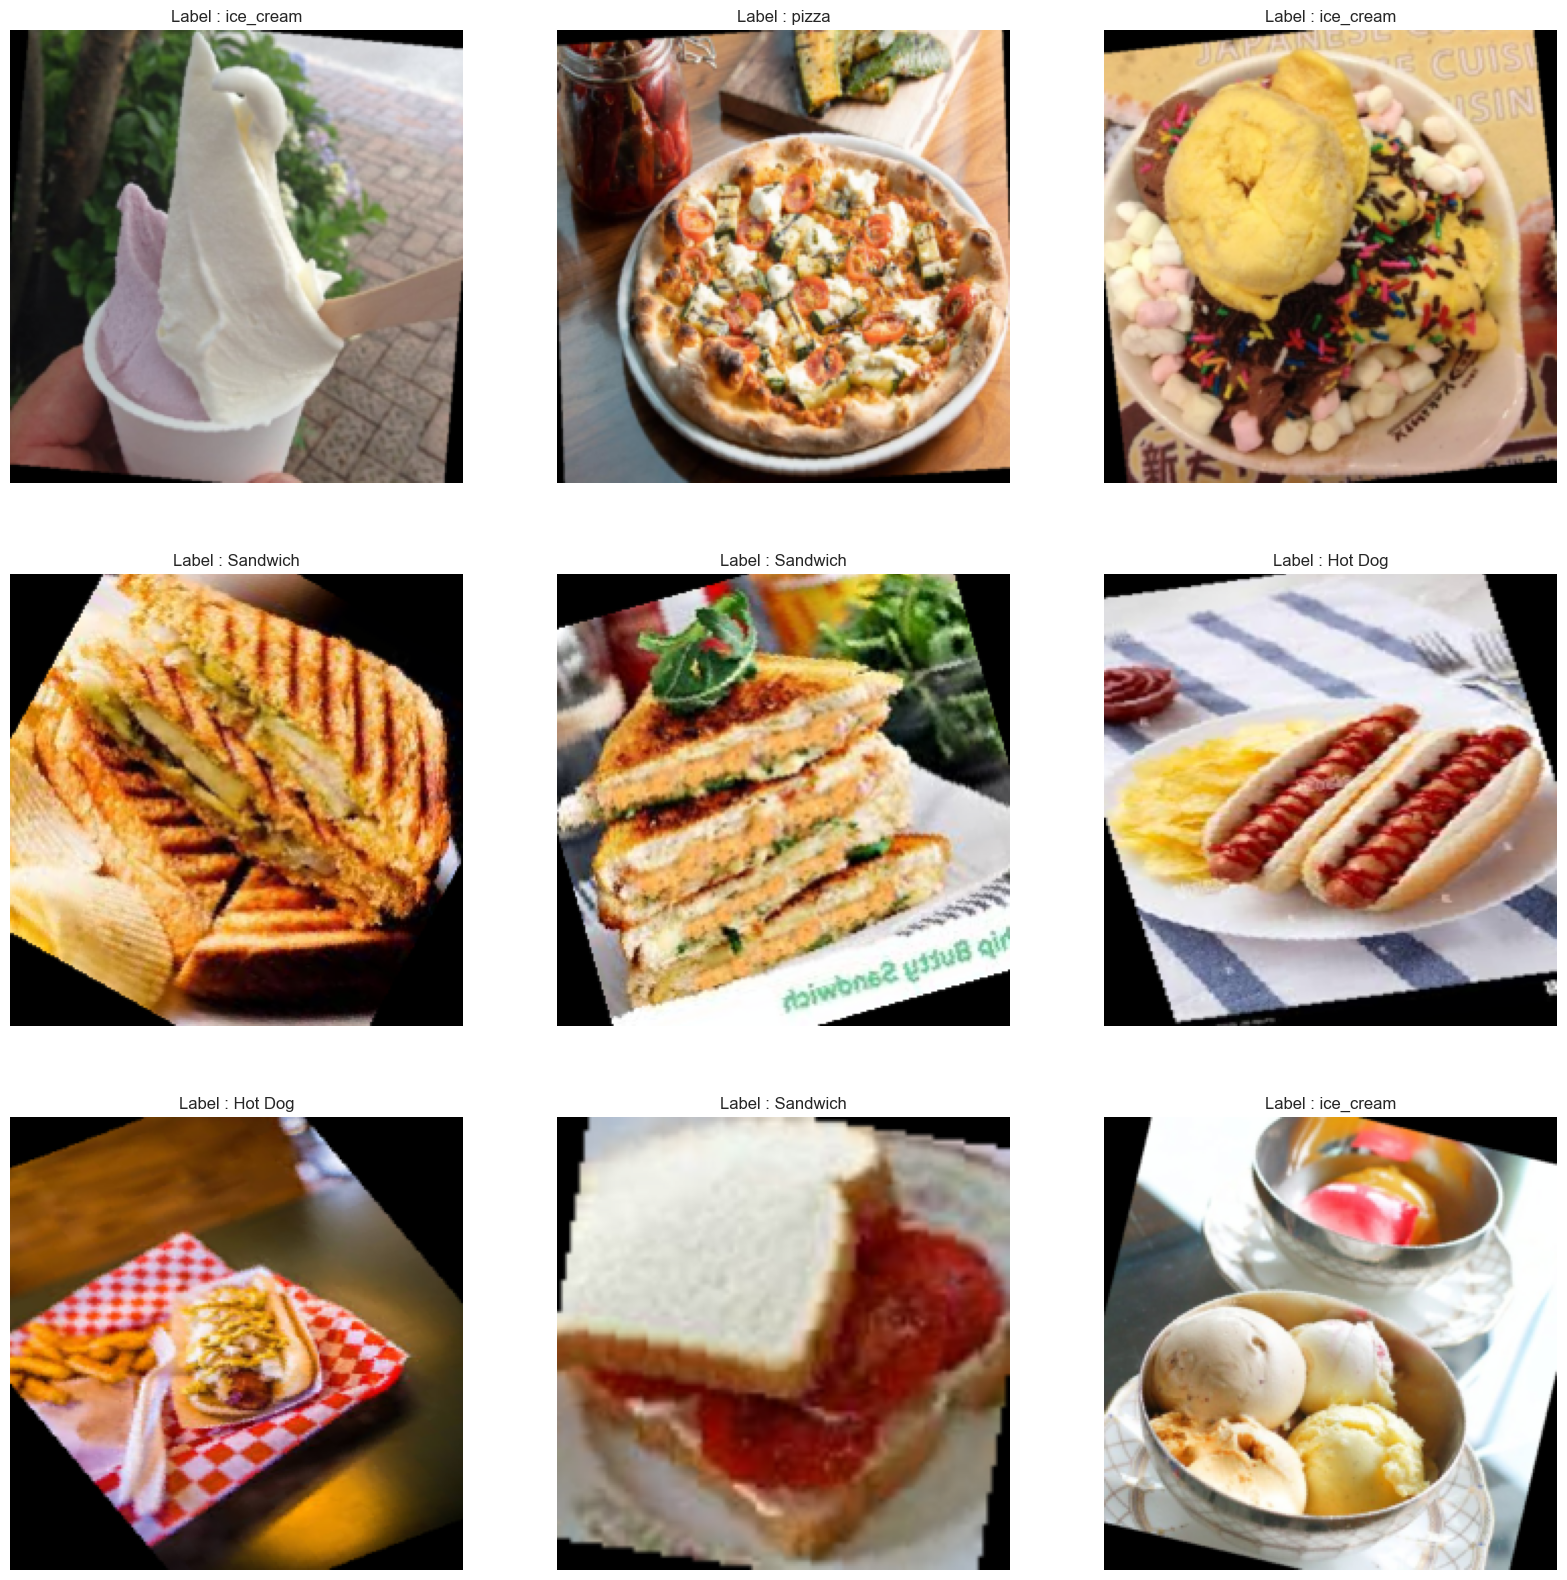

In [51]:
img, label = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].permute(1, 2, 0).numpy() * std + mean)
    plt.title(f'Label : {CLASS_NAMES[label[i]]}')
    plt.axis('off')

## Create Model

In [6]:
# Download resnet18
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Freeze all the layers bar the last one
for param in model_resnet18.parameters():
    param.requires_grad = False

model_resnet18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 8))

In [7]:
# Download vgg16
model_vgg16 = torchvision.models.vgg16(pretrained=True)

# Freeze all the layers bar the last one
for param in model_vgg16.parameters():
    param.requires_grad = False

# Newly created modules have require_grad=True by default
num_features = model_vgg16.classifier[6].in_features
features = list(model_vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features,8)]) # Add our layer with 4 outputs
model_vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

In [8]:
# Download efficientNetB3
model_efficientnetB3 = torchvision.models.efficientnet_b3(pretrained=True)

# Freeze all the layers bar the last one
for param in model_efficientnetB3.parameters():
    param.requires_grad = False

model_efficientnetB3_fc= nn.Sequential(
               nn.Linear(1536, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 8))

model_efficientnetB3.classifier = model_efficientnetB3_fc

## Train Model

In [9]:
def train_model(model):
    # Declaring Criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    since = time.time()
    epochs = 5
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for e in range(epochs):
        running_time = time.time()
        running_loss = 0.0
        total = 0
        correct = 0

        model.train(True)

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            
            
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs,labels)
            
            loss.backward()
            
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            

            running_loss += loss.item()

        train_acc.append(accuracy) 
        train_loss.append(running_loss)

        model.eval()
        total = 0
        correct = 0
        running_loss = 0.0   

        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs,labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            running_loss += loss.item()
            
        val_acc.append(accuracy)
        val_loss.append(running_loss)
        
        elapsed_running_time = time.time() - running_time
        print()
        print("Epoch {}/{}".format(e+1,epochs))
        print(f'{round(elapsed_running_time,2)}s - loss : {train_loss[e]} - accuracy : {train_acc[e]} - val loss : {val_loss[e]} - val acc {val_acc[e]}')
        
    
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

    return {
        "train_loss" : train_loss,
        "train_acc"  : train_acc,
        "val_loss"   : val_loss,
        "val_acc"    : val_acc,
        "model"      : model
    }

**Resnet Model**

In [10]:
resnet18_result = train_model(model_resnet18)


Epoch 1/5
380.61s - loss : 107.58719980716705 - accuracy : 68.1450447847443 - val loss : 7.075630687177181 - val acc 83.91203703703704

Epoch 2/5
374.97s - loss : 50.76818835735321 - accuracy : 84.38312626408552 - val loss : 7.001973584294319 - val acc 83.91203703703704

Epoch 3/5
374.65s - loss : 44.02900351583958 - accuracy : 85.84224212655302 - val loss : 8.253013301640749 - val acc 79.16666666666667

Epoch 4/5
370.51s - loss : 42.51109178364277 - accuracy : 86.73793701242415 - val loss : 7.6205123513937 - val acc 83.91203703703704

Epoch 5/5
368.89s - loss : 42.57240480929613 - accuracy : 86.57902340364056 - val loss : 5.557737708091736 - val acc 87.61574074074075

Training completed in 31m 10s


**VGG16 Model**

In [11]:
vgg16_result = train_model(model_vgg16)


Epoch 1/5
1699.76s - loss : 143.6476634889841 - accuracy : 75.64287778098816 - val loss : 10.499947100877762 - val acc 85.76388888888889

Epoch 2/5
1675.09s - loss : 124.54876974225044 - accuracy : 81.08928055475296 - val loss : 11.208956196904182 - val acc 86.57407407407408

Epoch 3/5
1838.21s - loss : 146.99196910858154 - accuracy : 81.06038717133777 - val loss : 12.67747913300991 - val acc 87.15277777777777

Epoch 4/5
1925.15s - loss : 165.96824499964714 - accuracy : 81.46489453915054 - val loss : 13.22939646244049 - val acc 87.38425925925925

Epoch 5/5
1810.81s - loss : 158.12117141485214 - accuracy : 82.53394972551285 - val loss : 12.486607164144516 - val acc 89.12037037037037

Training completed in 149m 9s


**EfficientNetB3 Model**

In [12]:
efficientnetB3_result = train_model(model_efficientnetB3)


Epoch 1/5
1197.85s - loss : 68.91652616858482 - accuracy : 78.73446980641432 - val loss : 5.4534652531147 - val acc 87.03703703703704

Epoch 2/5
1285.97s - loss : 45.90127031505108 - accuracy : 85.23548107483386 - val loss : 5.631875246763229 - val acc 88.42592592592592

Epoch 3/5
1168.37s - loss : 40.35505490005016 - accuracy : 87.22912453048252 - val loss : 5.19672204554081 - val acc 88.07870370370371

Epoch 4/5
1156.45s - loss : 35.4757938683033 - accuracy : 88.74602715978041 - val loss : 6.778686635196209 - val acc 87.15277777777777

Epoch 5/5
1145.91s - loss : 35.479157753288746 - accuracy : 88.57266685928923 - val loss : 6.0920397117733955 - val acc 87.73148148148148

Training completed in 99m 15s


### Compare Model

In [15]:
avg_val_resnet = np.mean(resnet18_result['val_acc'])
avg_val_vgg16 = np.mean(vgg16_result['val_acc'])
avg_val_efficientNetB3 = np.mean(efficientnetB3_result['val_acc'])

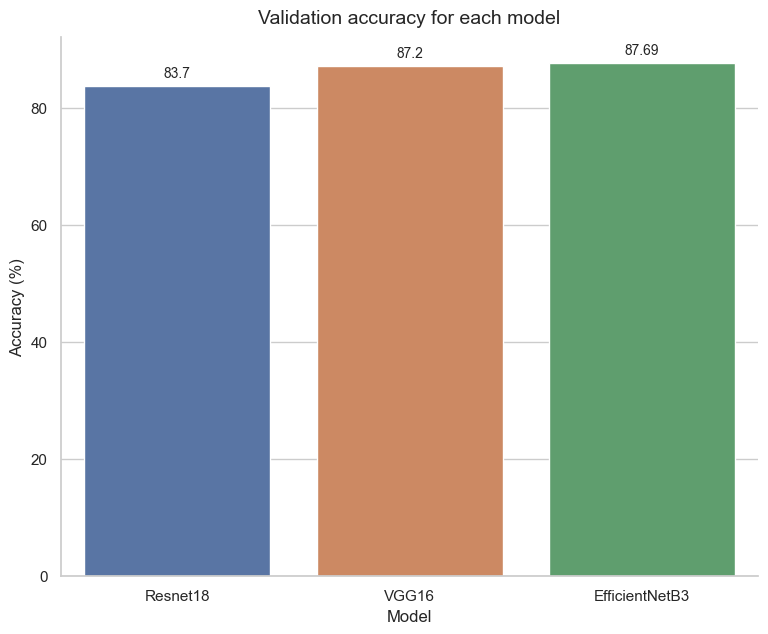

In [34]:
val_result = np.array([avg_val_resnet,avg_val_vgg16,avg_val_efficientNetB3])
model_names = ['Resnet18', 'VGG16', 'EfficientNetB3']

sns.set(style="whitegrid")
plt.figure(figsize=(9, 7))
ax = sns.barplot(x=model_names,y=val_result)

# Add labels and title
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Validation accuracy for each model",pad=10,fontsize=14)

sns.despine(top=True, right=True)
for i, v in enumerate(val_result):
    ax.text(i, v + 1 , str(round(v,2)), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

## Evaluation

### Evaluate using test set

In [35]:
def evaluation(model):
    criterion = nn.CrossEntropyLoss()
    since = time.time()
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0   

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs,labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        running_loss += loss.item()


    elapsed_time = time.time() - since
    print()
    print("Testing completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print(f'loss : {running_loss} - accuracy : {accuracy}')

In [36]:
evaluation(efficientnetB3_result['model'])


Testing completed in 2m 14s
loss : 5.395322360098362 - accuracy : 88.47926267281106


### Predict Images

In [64]:
def predictImages(img,model = efficientnetB3_result['model']):
    criterion = nn.CrossEntropyLoss()
    outputs = model(img)
    _, predicted = torch.max(outputs.data, 1)

    return predicted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


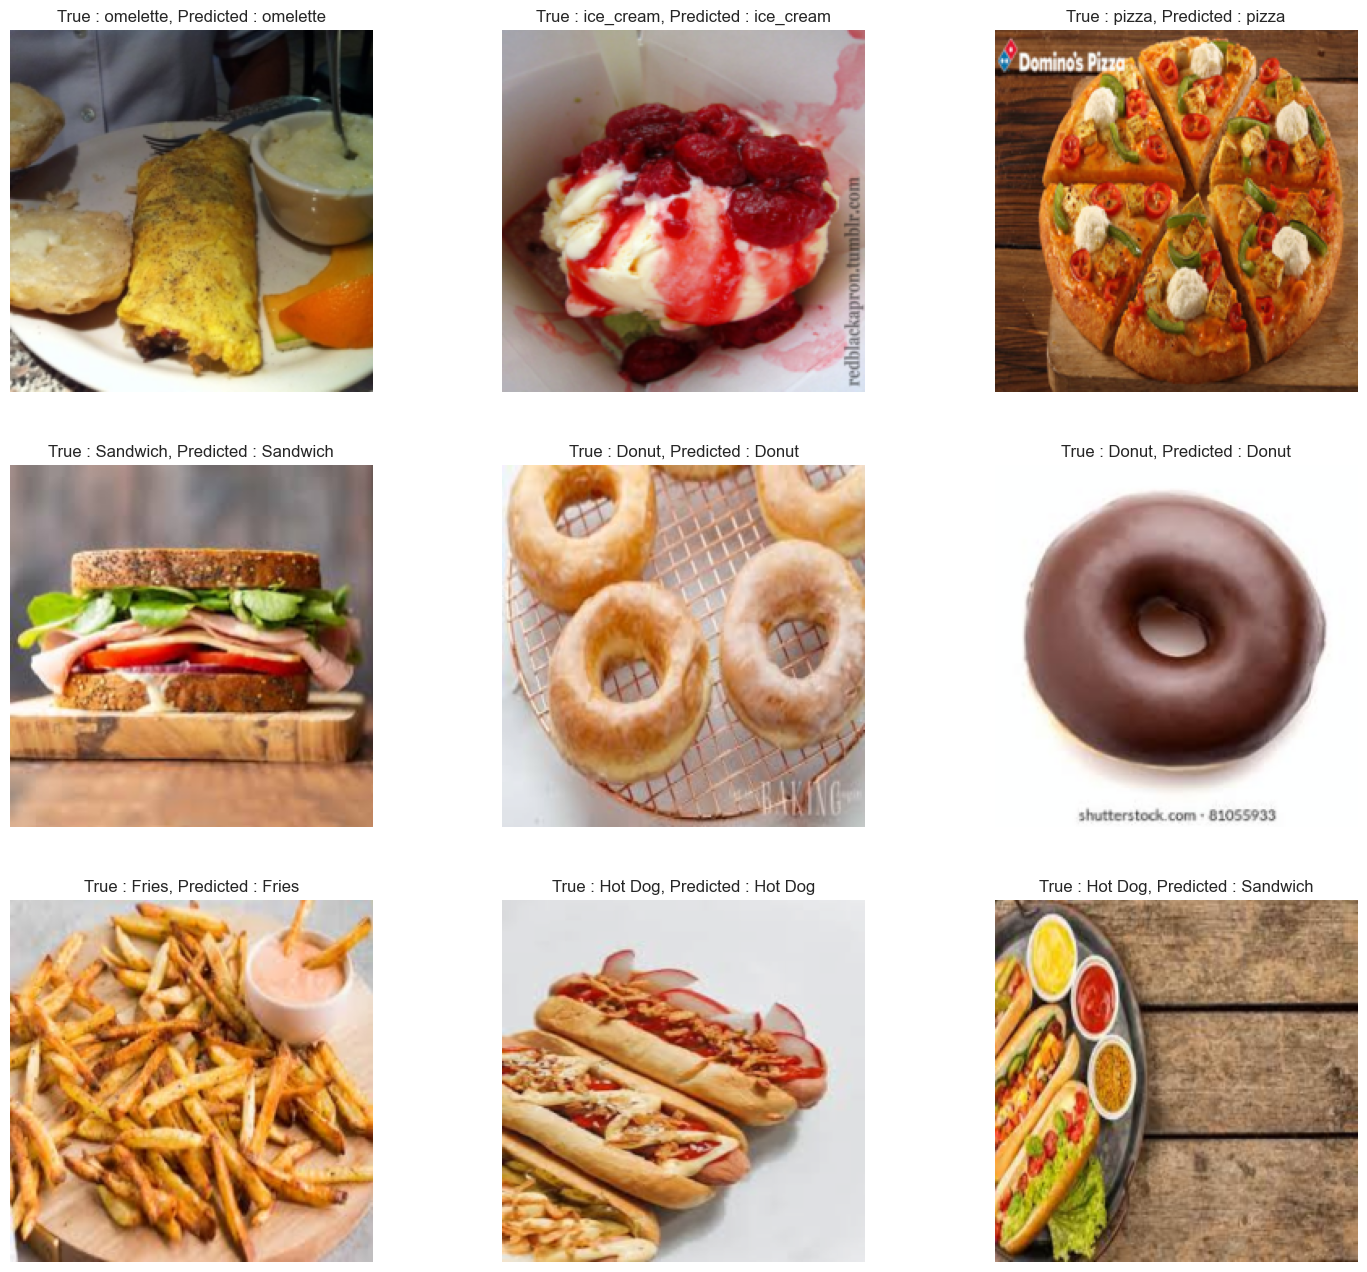

In [70]:
test_loader_predict = torch.utils.data.DataLoader(image_datasets['test'], batch_size=64,shuffle=True)
img, label = next(iter(test_loader_predict))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(18, 16))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img_pred = predictImages(img[i].unsqueeze(0))
    plt.imshow(img[i].permute(1, 2, 0).numpy() * std + mean)
    plt.title(f'True : {CLASS_NAMES[label[i]]}, Predicted : {CLASS_NAMES[img_pred]}')
    plt.axis('off')

## Save Model

In [74]:
torch.save(efficientnetB3_result['model'], 'model/efficientNet_model.pth')